# EE5178 Assignment 2
## Vaibhav Mahapatra
### ME19B197

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Reading the Image

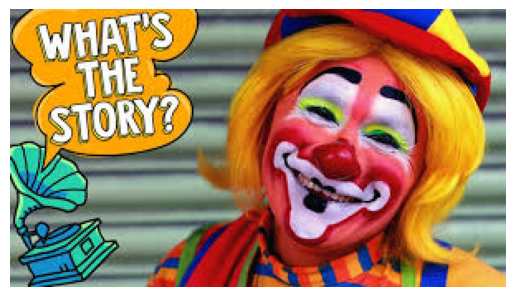

In [2]:
img = cv2.imread("clown.jpeg")
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))  # Swapping from BGR to RGB to display
plt.axis("off");

# Converting Image to Grayscale


### Strategy 1: Simple Averaging across channels

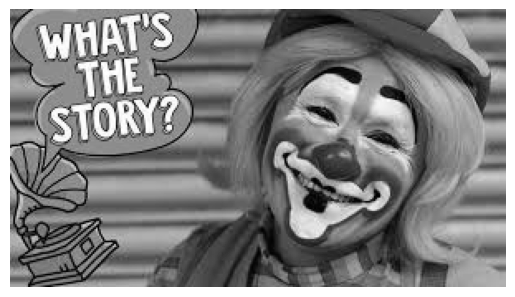

In [3]:
gray = img.mean(axis=2).astype(np.uint8)
plt.imshow(gray,cmap='gray')
plt.axis("off");

### Strategy 2: Weighted Average using [NTSC](https://support.ptc.com/help/mathcad/r9.0/en/index.html\#page/PTC_Mathcad_Help/example_grayscale_and_color_in_images.html) formula
The NTSC formula is based on the human eye's perception of brightness with respect to each colour. The formula is a s follows:

Gray = 0.299 Red + 0.587 Green + 0.114 Blue

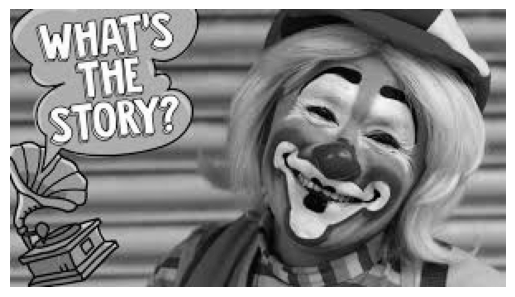

In [4]:
ntsc = (0.299*img[:,:,2] + 0.587*img[:,:,1] + 0.114*img[:,:,0]).astype(np.uint8)
plt.imshow(ntsc, cmap="gray")
plt.axis("off");

### Strategy 3: Using OpenCV function

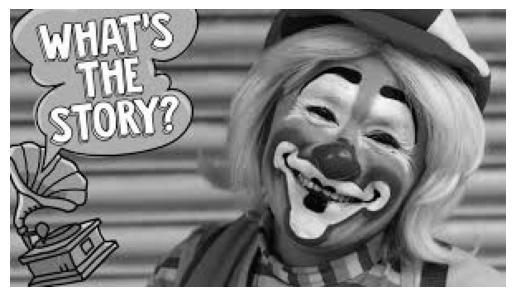

In [5]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap="gray")
plt.axis("off");

# Gaussian Filtering for Noise Suppression

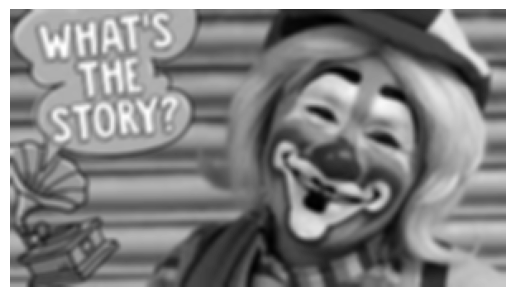

In [6]:
# Using inbuilt cv2 function to generate and convolve the gaussian filter
kernel_size = (5,5)
sigma = 1.5
img_blur = cv2.GaussianBlur(img_gray,ksize=kernel_size,sigmaX=sigma)
plt.imshow(img_blur,cmap='gray')
plt.axis("off");

# Sobel Operators

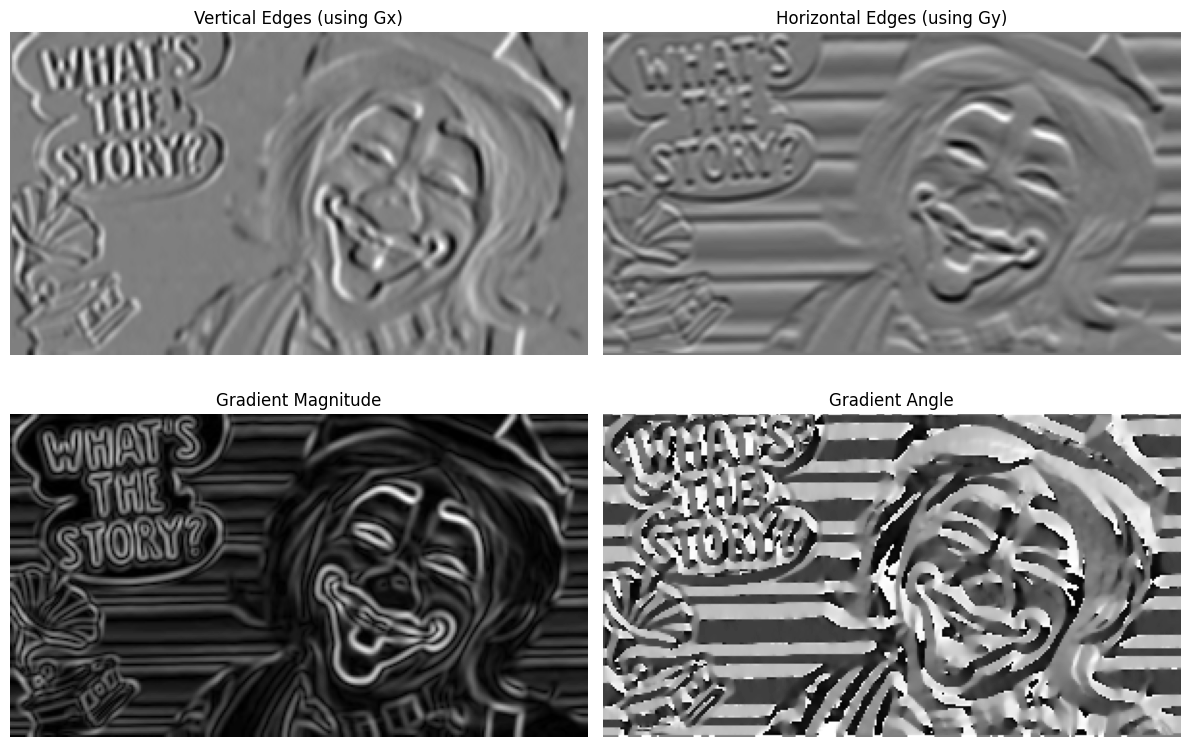

In [7]:
# Using inbuild opencv functions for applying the sobel function to our image
Gx = cv2.Sobel(img_blur, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
Gy = cv2.Sobel(img_blur, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)
Theta = np.arctan2(Gy, Gx)
Mag = (Gx**2 + Gy**2) ** 0.5
Mag = (255 * Mag / np.max(Mag)).astype(np.uint8)

fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs[0,0].imshow(Gx, cmap='gray')
axs[0,0].set_title("Vertical Edges (using Gx)")
axs[0,0].axis("off")

axs[0,1].imshow(Gy, cmap='gray')
axs[0,1].set_title("Horizontal Edges (using Gy)")
axs[0,1].axis("off")

axs[1,0].imshow(Mag, cmap='gray')
axs[1,0].set_title("Gradient Magnitude")
axs[1,0].axis("off")

axs[1,1].imshow(Theta, cmap='gray')
axs[1,1].set_title("Gradient Angle")
axs[1,1].axis("off")
plt.tight_layout();


# Non-Maximum Suppression

In [8]:
def get_neighbours_ij(i,j,angle):
    '''
    Function to retrieve neighbouring indices to i,j based on angle
    '''
    if (angle < 22.5) or (157.5 <= angle <= 180):
        neighs = [(i,j+1),(i,j-1)]

    elif (22.5 <= angle < 67.5):
        neighs = [(i+1,j-1),(i-1,j+1)]

    elif (67.5 <= angle < 112.5):
        neighs = [(i-1,j),(i+1,j)]

    elif (112.5 <= angle < 157.5):
        neighs = [(i-1,j-1),(i+1,j+1)]

    return neighs

In [9]:
def apply_nonmaximal_suppression(Theta, Mag):
    # Suppressing range from [0,2*pi] to [0,pi] as only orientation information is needed
    Theta = Theta.copy()
    Theta[Theta<0] += np.pi
    Theta = Theta*180/np.pi

    res_img = np.zeros_like(Theta)
    for i in range(1,Theta.shape[0]-1):
        for j in range(1,Theta.shape[1]-1):
            angle = Theta[i,j]
            mag = Mag[i,j]
            n1,n2 = get_neighbours_ij(i,j,angle)
            mag1, mag2 = Mag[n1[0],n1[1]], Mag[n2[0],n2[1]]

            # Suppressing pixel to 0 if it is not a local maximum
            if mag>=mag1 and mag>=mag2:
                res_img[i,j] = 1
            else:
                res_img[i,j] = 0

    return res_img

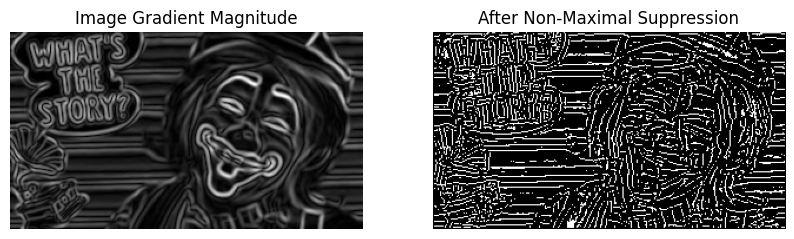

In [10]:
nonmaxsup_img = apply_nonmaximal_suppression(Theta, Mag)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(Mag, cmap='gray')
axs[0].set_title("Image Gradient Magnitude")
axs[0].axis("off")

axs[1].imshow(nonmaxsup_img,cmap='gray')
axs[1].set_title("After Non-Maximal Suppression")
axs[1].axis("off");

# Simple Thresholding

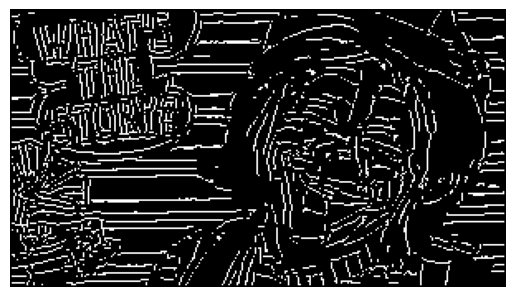

In [11]:
threshold = np.median(Mag)
img_thresholded = np.zeros_like(Mag)
img_thresholded[Mag * nonmaxsup_img > threshold] = 255

plt.imshow(img_thresholded,cmap='gray')
plt.axis("off");

# Defining Canny Edge Detector, and comparing results with Gausian filter of sigma = 3

In [12]:
class CannyEdgeDetector:
  def __init__(self, gauss_size, gauss_sig, sobel_size):
    self.gauss_size = gauss_size
    self.gauss_sig = gauss_sig
    self.sobel_size = sobel_size

  def conv2gray(self, image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  def blurimage(self, image):
    if len(image.shape) == 3:
      image = self.conv2gray(image)
    return cv2.GaussianBlur(image, ksize=self.gauss_size, sigmaX=self.gauss_sig)

  def applySobel(self, image):
    Gx = cv2.Sobel(img_blur, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=self.sobel_size)
    Gy = cv2.Sobel(img_blur, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=self.sobel_size)
    Theta = np.arctan2(Gy, Gx)
    Mag = (Gx**2 + Gy**2) ** 0.5
    return Theta, Mag

  def get_neighbours(self, i, j, angle):
    if (angle < 22.5) or (157.5 <= angle <= 180):
      neighs = [(i,j+1),(i,j-1)]
    elif (22.5 <= angle < 67.5):
      neighs = [(i+1,j-1),(i-1,j+1)]
    elif (67.5 <= angle < 112.5):
      neighs = [(i-1,j),(i+1,j)]
    elif (112.5 <= angle < 157.5):
      neighs = [(i-1,j-1),(i+1,j+1)]
    return neighs

  def apply_nonmaximal_suppression(self, Theta, Mag):
    Theta = Theta.copy()
    Theta[Theta<0] += np.pi
    Theta = Theta*180/np.pi

    res_img = np.zeros_like(Theta)
    for i in range(1,Theta.shape[0]-1):
      for j in range(1,Theta.shape[1]-1):
        angle = Theta[i,j]
        mag = Mag[i,j]
        n1,n2 = get_neighbours_ij(i,j,angle)
        mag1, mag2 = Mag[n1[0],n1[1]], Mag[n2[0],n2[1]]
        if mag>=mag1 and mag>=mag2:
            res_img[i,j] = 1
        else:
            res_img[i,j] = 0
    return res_img

  def detect_edges(self, image):
    img_gray = self.conv2gray(image)
    img_blur = self.blurimage(img_gray)
    img_theta, img_mag = self.applySobel(img_blur)
    img_nonmaxsup = self.apply_nonmaximal_suppression(img_theta, img_mag)

    img_thresholded = np.zeros_like(img_mag)
    img_thresholded[img_mag * img_nonmaxsup > np.median(img_mag)] = 255

    results = {
        "original_img": cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        "gray": img_gray,
        f"img_blur with sig={self.gauss_sig}": img_blur,
        "img_theta": img_theta,
        "img_mag": img_mag,
        "non_max_suppression": img_nonmaxsup,
        "img_thresholded": img_thresholded
        }

    return results

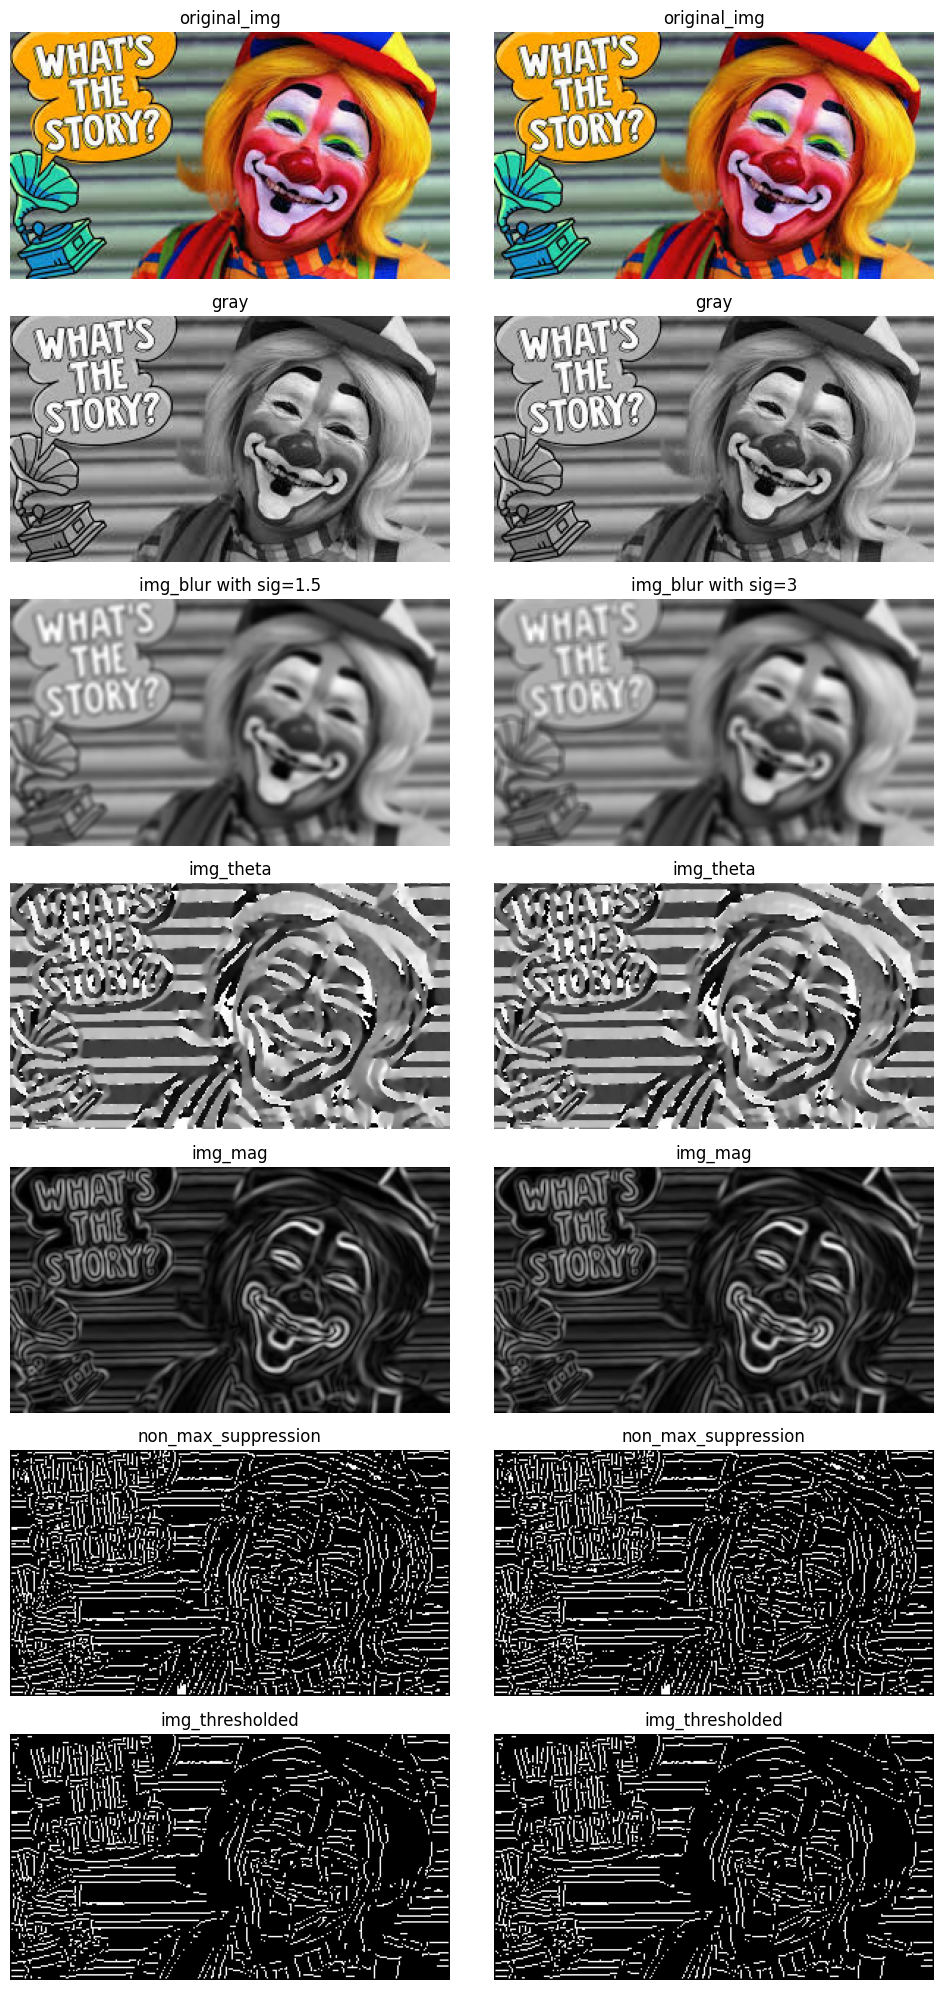

In [13]:
detector1 = CannyEdgeDetector(gauss_size=(5,5), gauss_sig=1.5, sobel_size=3)
res1 = detector1.detect_edges(img)

detector2 = CannyEdgeDetector(gauss_size=(5,5), gauss_sig=3, sobel_size=3)
res2 = detector2.detect_edges(img)

fig, axs = plt.subplots(7, 2, figsize=(10,20))
for i, (key,image) in enumerate(res1.items()):
    axs[i,0].imshow(image,cmap='gray')
    axs[i,0].axis("off")
    axs[i,0].set_title(key)

for i, (key,image) in enumerate(res2.items()):
    axs[i,1].imshow(image,cmap='gray')
    axs[i,1].axis("off")
    axs[i,1].set_title(key)

plt.tight_layout()

Main takeaways from this experiment:
- Lower sigma gives us a sharper image
- Higher sigma blurs the image more, leading to less edges detected
- Finer details are lost with higher sigma. To retain finer images, we should use a lower sigma, but that will be more sensitive to noise
- The results can be enhanced with double thresholding hysterisis instead of single threshold
- Additionally, results cna be improved by performing interpolation during the non-maximal suppression step